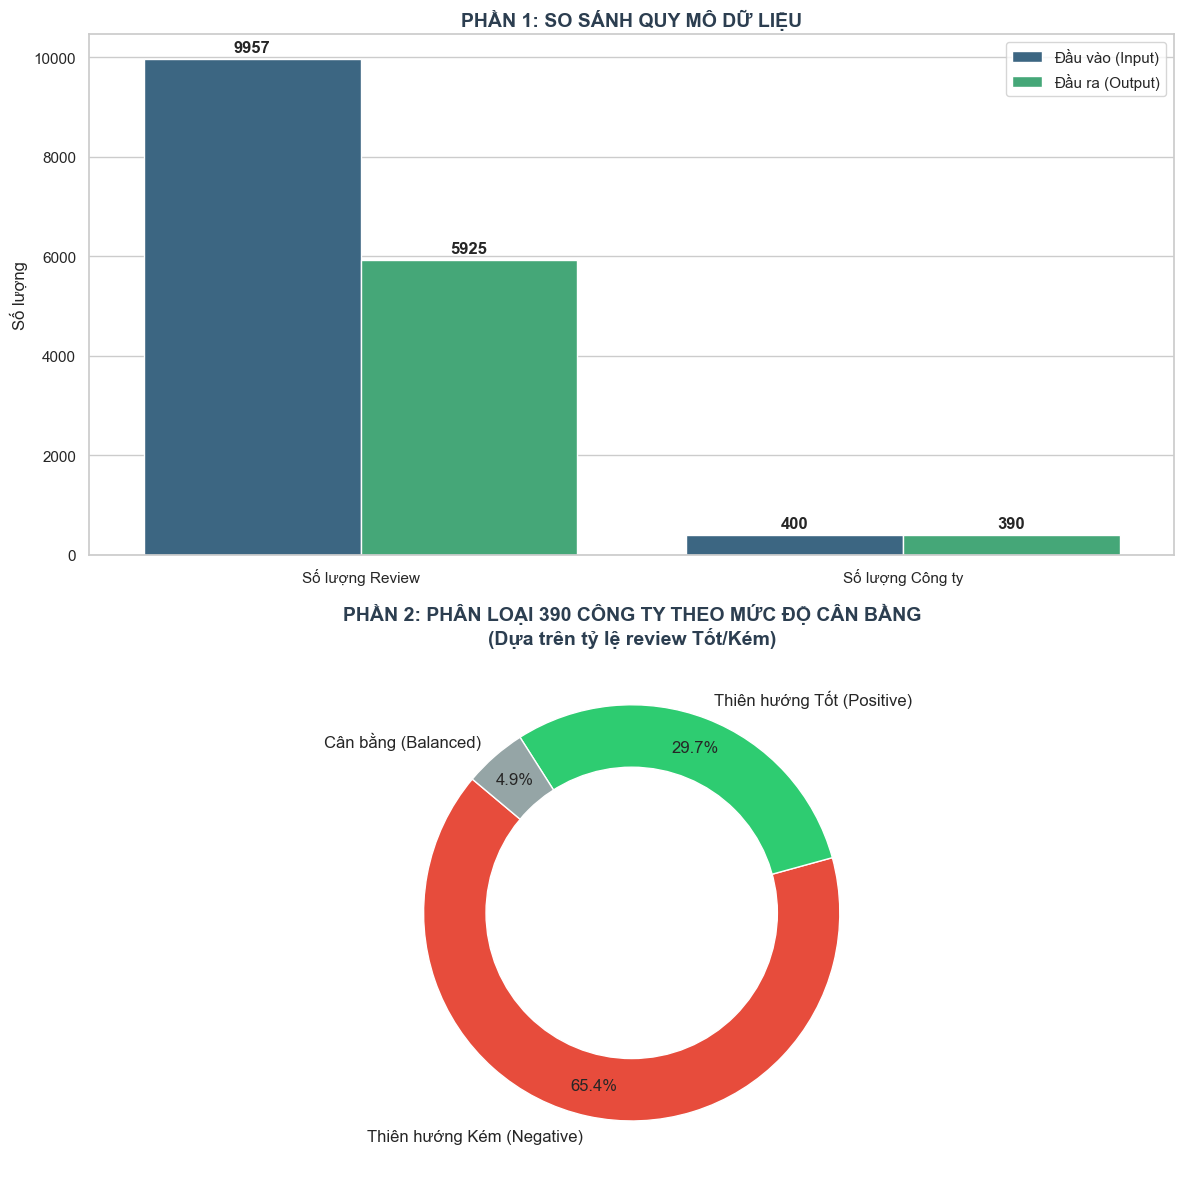


--- THỐNG KÊ CHI TIẾT ---
1. Số liệu so sánh:
Giai đoạn         Đầu ra (Output)  Đầu vào (Input)
Loại                                              
Số lượng Công ty              390              400
Số lượng Review              5925             9957

2. Phân loại các công ty (Mức độ cân bằng):
Status
Thiên hướng Kém (Negative)    255
Thiên hướng Tốt (Positive)    116
Cân bằng (Balanced)            19
Name: count, dtype: int64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CẤU HÌNH ---
input_file = r"E:\linhtinh\DangHoc\Khai thác dữ liệu\Tech_Job_Radar\Tech_Job_Radar\Tech_Job_Radar\data\processed\clean_data_filtered.csv"   # File gốc
output_file = r"E:\linhtinh\DangHoc\Khai thác dữ liệu\Tech_Job_Radar\Tech_Job_Radar\Tech_Job_Radar\data\processed\MERGED_FINAL_CLEAN.csv"    # File kết quả

# --- XỬ LÝ DỮ LIỆU ---

# 1. Đọc dữ liệu
if os.path.exists(input_file):
    try: df_in = pd.read_csv(input_file, encoding='utf-8-sig')
    except: df_in = pd.read_csv(input_file, encoding='utf-8')
else: df_in = pd.DataFrame()

if os.path.exists(output_file):
    try: df_out = pd.read_csv(output_file, encoding='utf-8-sig')
    except: df_out = pd.read_csv(output_file, encoding='utf-8')
else: df_out = pd.DataFrame()

# 2. Chuẩn bị dữ liệu so sánh Input/Output
comparison_data = []
if not df_in.empty:
    comparison_data.append({'Giai đoạn': 'Đầu vào (Input)', 'Loại': 'Số lượng Review', 'Giá trị': len(df_in)})
    comparison_data.append({'Giai đoạn': 'Đầu vào (Input)', 'Loại': 'Số lượng Công ty', 'Giá trị': df_in['Ten_Cong_Ty'].nunique()})

if not df_out.empty:
    comparison_data.append({'Giai đoạn': 'Đầu ra (Output)', 'Loại': 'Số lượng Review', 'Giá trị': len(df_out)})
    comparison_data.append({'Giai đoạn': 'Đầu ra (Output)', 'Loại': 'Số lượng Công ty', 'Giá trị': df_out['Ten_Cong_Ty'].nunique()})

df_comparison = pd.DataFrame(comparison_data)

# 3. TÍNH TOÁN MỨC ĐỘ CÂN BẰNG (SENTIMENT BALANCE) CỦA CÁC CÔNG TY (PHẦN MỚI)
# Logic: Với mỗi công ty, đếm tổng số Tốt và Kém.
# - Nếu Tốt > Kém: Công ty Thiên hướng Tốt (Positive)
# - Nếu Kém > Tốt: Công ty Thiên hướng Kém (Negative)
# - Nếu Bằng nhau hoặc chỉ toàn Bình thường: Cân bằng (Balanced)

company_stats = []
if not df_out.empty:
    # Các cột đánh giá
    categories = ['Dai_Ngo', 'Van_Hoa', 'Lanh_Dao', 'Phat_Trien']
    
    # Gom nhóm theo công ty
    grouped = df_out.groupby('Ten_Cong_Ty')
    
    for company, group in grouped:
        good_count = 0
        bad_count = 0
        
        for col in categories:
            vals = group[col].astype(str).str.strip().str.lower()
            good_count += (vals == 'tốt').sum()
            bad_count += (vals == 'kém').sum()
        
        if good_count > bad_count:
            status = 'Thiên hướng Tốt (Positive)'
        elif bad_count > good_count:
            status = 'Thiên hướng Kém (Negative)'
        else:
            status = 'Cân bằng (Balanced)'
            
        company_stats.append(status)

    df_balance = pd.DataFrame(company_stats, columns=['Status'])
    balance_counts = df_balance['Status'].value_counts()

# --- VẼ BIỂU ĐỒ (2 PHẦN) ---
if not df_comparison.empty:
    fig, axes = plt.subplots(2, 1, figsize=(12, 12)) # 2 biểu đồ dọc
    sns.set(style="whitegrid")

    # BIỂU ĐỒ 1: SO SÁNH INPUT vs OUTPUT
    sns.barplot(data=df_comparison, x='Loại', y='Giá trị', hue='Giai đoạn', palette='viridis', ax=axes[0])
    axes[0].set_title('PHẦN 1: SO SÁNH QUY MÔ DỮ LIỆU', fontsize=14, fontweight='bold', color='#2c3e50')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Số lượng')
    axes[0].legend(loc='upper right')
    for container in axes[0].containers:
        axes[0].bar_label(container, padding=3, fontweight='bold')

    # BIỂU ĐỒ 2: THỐNG KÊ MỨC ĐỘ CÂN BẰNG CỦA CÔNG TY (PHẦN MỚI)
    if not df_out.empty:
        # Màu sắc: Xanh (Tốt), Đỏ (Kém), Xám (Cân bằng)
        colors = ['#e74c3c', '#2ecc71', '#95a5a6'] # Thứ tự thường là Negative, Positive, Balanced do value_counts sắp xếp
        # Để chắc chắn màu đúng, ta map thủ công
        color_dict = {'Thiên hướng Tốt (Positive)': '#2ecc71', 'Thiên hướng Kém (Negative)': '#e74c3c', 'Cân bằng (Balanced)': '#95a5a6'}
        pie_colors = [color_dict.get(idx, '#333') for idx in balance_counts.index]

        axes[1].pie(balance_counts, labels=balance_counts.index, autopct='%1.1f%%', 
                    startangle=140, colors=pie_colors, textprops={'fontsize': 12}, pctdistance=0.85)
        
        # Vẽ vòng tròn trắng ở giữa (Donut)
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        axes[1].add_artist(centre_circle)
        
        axes[1].set_title(f'PHẦN 2: PHÂN LOẠI {len(company_stats)} CÔNG TY THEO MỨC ĐỘ CÂN BẰNG\n(Dựa trên tỷ lệ review Tốt/Kém)', fontsize=14, fontweight='bold', color='#2c3e50')
    
    plt.tight_layout()
    plt.show()
    
    # In bảng số liệu chi tiết
    print("\n--- THỐNG KÊ CHI TIẾT ---")
    print("1. Số liệu so sánh:")
    print(df_comparison.pivot(index='Loại', columns='Giai đoạn', values='Giá trị'))
    print("\n2. Phân loại các công ty (Mức độ cân bằng):")
    print(balance_counts)
else:
    print(" Không có dữ liệu để vẽ.")